In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import networkx as nx
import markov_clustering as mc
import matplotlib

In [2]:
output_path = '/home/bruce1996/data/pr/0809/'

In [3]:
metaphlan_output = "/home/bruce1996/data/MCI/metaphlan_result/formated_mci_metaphlan_table.txt"
metadata = pd.read_csv('/home/bruce1996/data/MCI/metadata/MCI_label.txt',sep = '\t',index_col=0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
meta_df.columns = [x.split('_')[0] for x in meta_df.columns]

selected_df = pd.read_csv("/home/bruce1996/repo/MCI_PGD/total_selected_feature.txt",sep = '\t',header=None)
selected_s = selected_df.iloc[:,0].values
candidate_df = meta_df.loc[selected_s,:]

consensus_cluster = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/consensus_clustering.txt',sep='\t',index_col=0)
consensus_cluster = consensus_cluster.loc[candidate_df.columns,:]

In [8]:
candidate_df.columns.names = ['Subject_id']

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = candidate_df.T.to_numpy()
x = scaler.fit_transform(X)
candidate_std_df = pd.DataFrame(x.T,index=candidate_df.index,columns=candidate_df.columns)
lefse_df = pd.concat([consensus_cluster.T,candidate_std_df],axis=0)

In [14]:
lefse_df.to_csv('/home/bruce1996/data/MCI/metaphlan_result/candidate_df_consensus_cluster_for_lefse.txt',sep = '\t')

In [6]:
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0)

### humann result

In [7]:
humann_tsea = pd.read_csv('/home/bruce1996/data/MCI/tsea/Humann-tsea-result.txt',sep='\t',index_col=0)
keep_idx = humann_tsea['Node-pseudo-F'].values  + humann_tsea['Edge-pseudo-F'].values > 0
humann_tsea = humann_tsea.loc[keep_idx,:]

In [8]:
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., 20))
matplotlib.colors.rgb2hex(colors[2])

idx = (humann_tsea['Node-pseudo-F'] < 0.05) & (humann_tsea['Edge-pseudo-F'] < 0.05)
sig_path = humann_tsea.loc[idx,:]

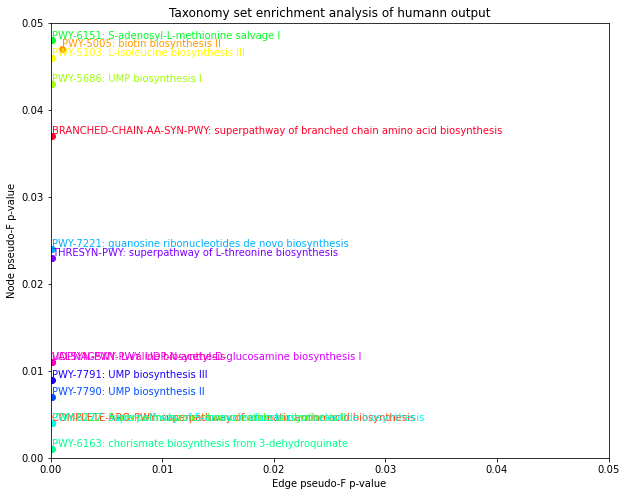

In [60]:
n = sig_path.shape[0]
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., n))
plt.figure(figsize=(10,8))
plt.xlim([0,0.05])
plt.ylim([0,0.05])
for i in range(n) :
    s,n,e = sig_path.iloc[i,:]
    c = matplotlib.colors.rgb2hex(colors[i])
    plt.scatter(e,n,color= c)
    plt.text(e,n,s,fontsize = 10,color = c,rotation=0,horizontalalignment='left',verticalalignment='bottom')  
plt.ylabel('Node pseudo-F p-value')
plt.xlabel('Edge pseudo-F p-value')
plt.title('Taxonomy set enrichment analysis of humann output')
plt.savefig(output_path + 'Humann-tsea-scatterplot-cross-threshold.png',dpi = 300)    

## Functions

### Network module

In [70]:
from scipy.stats import spearmanr,scoreatpercentile

###calculate z score
def zscore_dict(df,fisher_z_transform =True) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            n_sample = sum(idx)
            r,p = spearmanr(t1[idx],t2[idx])
            if fisher_z_transform :
                z = np.arctanh(r) * np.sqrt(n_sample - 3)
                corr_z_dict[name] = z
            else :
                corr_z_dict[name] = r
    return corr_z_dict

def zscore_percentile(corr_z_dict,pr) :
    z_list = list(corr_z_dict.values())
    percentile=scoreatpercentile(z_list, pr)
    return percentile

def zscore_hist(corr_z_dict,output_path,title) :

    z_list = list(corr_z_dict.values())
    df = pd.DataFrame({'z-score' : z_list})
    plt.figure(figsize=(8,5))
    sns.histplot(data = df,x = 'z-score',kde=True,stat='percent',bins=10,palette='Set2')
    plt.title(title)
    plt.savefig(output_path)

###network module
def create_corr_network(df,fisher_z_transform=True) :
    n = df.shape[0]
    corr_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            if fisher_z_transform :
                idx = (t1 + t2) > 0
                n_sample = sum(idx)
                r,p = spearmanr(t1[idx],t2[idx])
                z = np.arctanh(r) * np.sqrt(n - 3)
                corr_dict[name] = z
            else :
                r,p = spearmanr(t1,t2)
                corr_dict[name] = r

    g = nx.Graph()
    g.add_nodes_from(df.index)
    #only add edge
    g.add_edges_from(corr_dict)
    #add z score of edge to graph object
    nx.set_edge_attributes(g,corr_dict,'weight')
    #add node attribute
    pv_lambda = lambda x : 100 * (sum(x > 0) / len(x))
    pv = list(map(pv_lambda,df.to_numpy()))
    pv_dict = dict(zip(df.index,pv))

    m_ab = df.mean(axis=1)
    mab_dict = dict(zip(df.index,m_ab))
    nx.set_node_attributes(g,pv_dict,name='Prevalence')
    nx.set_node_attributes(g,mab_dict,name='Mean abundance')

    return g


def filter_corr_network(g,threshold,pos_only=False,remove_node=True,p_color = '#66c2a5',n_color='#fc8d62'):
    g_c = g.copy()
    color_dict = dict()
    #p_color = ImageColor.getcolor(p_color, "RGB")
    #n_color = ImageColor.getcolor(n_color, "RGB")
    for n1,n2,w in g_c.edges(data=True) :
        if pos_only :
            if w['weight'] < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
        else :
            if abs(w['weight']) < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
    nx.set_edge_attributes(g,color_dict,name='Color')
    #remove node degree = 1
    if remove_node :
        g_c = g.copy()
        for n,d in g_c.degree :
            if d < 2 :
                g.remove_node(n)

def sort_taxonomy_for_tsea(df) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            r,p = spearmanr(t1[idx],t2[idx])
            z = np.arctanh(r)
            corr_z_dict[name] = z
    df = pd.DataFrame({'Name' : corr_z_dict.keys(),'z-score' : corr_z_dict.values()}).sort_values(by='z-score',ascending=False)
    return list(df['Name'].values)

def subgraph(g,candidate,attr) :
    g_c = g.copy()
    cl = list(nx.get_node_attributes(g,attr).values())
    nl = list(g.nodes())
    for i in range(len(cl)) :
        if cl[i] != candidate :
            g_c.remove_node(nl[i])
    return g_c

### MCL module

In [63]:
### mcl module
def mcl_clustering(G) :

    matrix = nx.to_scipy_sparse_matrix(G,dtype=np.float32)
    result = mc.run_mcl(matrix)           
    clusters = mc.get_clusters(result)

    cluster_dict = dict()
    color_dict = dict()
    #set color for mcl clusters
    cmap = plt.cm.gist_rainbow
    n_cluster = len(clusters)
    colors = cmap(np.linspace(0., 1., n_cluster))

    node_list = list(G.nodes().keys())
    n_c = 0
    for i in range(len(clusters)) :
        if len(clusters[i]) < 2 :
            n = node_list[clusters[i][0]]
            cluster_dict[n] = 'No cluster'
            color_dict[n] = matplotlib.colors.rgb2hex(np.array([192/255,192/255,192/255,1]))
        else :
            for j in range(len(clusters[i])) :
                n = node_list[clusters[i][j]]
                cluster_dict[n] = "Cluster " + str(n_c)
                color_dict[n] = matplotlib.colors.rgb2hex(colors[n_c])
            n_c += 1
    nx.set_node_attributes(G,cluster_dict,'Cluster')
    nx.set_node_attributes(G,color_dict,'Color')

def number_of_mcl_cluster(g) :
    cl = list(nx.get_node_attributes(g,'Cluster').values())
    nl = list(g.nodes().keys())
    degree_list = [x[1] for x in g.degree]
    df = pd.DataFrame({'Species' : nl,'Cluster' : cl,'Degree' : degree_list})
    for i in list(set(df['Cluster'])) :
        num = sum(df['Cluster'] == i)
        print('Number of node in %s : %d' % (i,num))

### plot module

In [64]:
### plot module
def plot_corr_network(G,title,fig_output,random_layout=False,fontsize=None,figsize = (20,12)) :

    plt.figure(figsize = figsize)
    #pos = nx.spring_layout(G,k = 4 / sqrt(G.order()))
    if random_layout :
        pos = nx.random_layout(G)
    else :
        pos = nx.spring_layout(G)
    #pos = nx.multipartite_layout(G,subset_key='Cluster')
    #plot node
    node_color_list = nx.get_node_attributes(G,'Color').values()
    nx.draw_networkx_nodes(G,pos,node_color=node_color_list,alpha=0.8,node_size = [v[1] ** 2 for v in G.degree]) 
    species = list(pos.keys())
    for idx in range(len(pos)) :
        s = species[idx]
        x = pos[s][0]
        y = pos[s][1]
        if fontsize == None :
            plt.text(x,y,s,fontsize = G.degree[s],horizontalalignment='center',verticalalignment='center')  
        else :
            plt.text(x,y,s,fontsize = fontsize,horizontalalignment='center',verticalalignment='bottom')
    #plot edge
    edge_color = nx.get_edge_attributes(G,'Color').values()
    nx.draw_networkx_edges(G,pos,edge_color=edge_color)
    #plot legend
    node_cluser_list = nx.get_node_attributes(G,'Cluster').values()
    legend_dict = dict(zip(node_cluser_list,node_color_list))
    
    for cl,col in legend_dict.items() :
        plt.plot([],[],color = col,label = cl)
    
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.savefig(fig_output)
    plt.show()

def degree_barplot(G,title,fig_output) :
    
    n_node = len(G.nodes())
    d_array = np.empty(n_node,dtype=int)
    n_array = np.empty(n_node,dtype=object)
    idx = 0
    for n,d in G.degree() :
        n_array[idx] = n
        d_array[idx] = d
        idx += 1
    plot_df = pd.DataFrame({'Species' : n_array,'Degree' : d_array})
    plot_df = plot_df.sort_values(by='Degree',ascending=False)
    plt.figure(figsize=(15,6))
    sns.barplot(data=plot_df,x='Species',y='Degree')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(fig_output,dpi=300)

def node_scatter_plot(G,df,label,title,fig_output,xlabel,ylabel,measure='pv') :
    s = list(G.nodes)
    df = df.loc[s,:]
    if measure == 'pv' :
        pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
        x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
        y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    elif measure == 'mab' :
        x = df.loc[:,label].mean(axis=1)
        y = df.loc[:,label == False].mean(axis=1)
    plt.scatter(x = x,y=y,c=y,cmap='rainbow')
    mi= min(min(x),min(y))
    ma = max(max(x),max(y))
    plt.plot([0,ma],[0,ma], 'r-')

    if measure == 'pv' :
        plt.xlim([mi-5,ma+5])
        plt.ylim([mi-5,ma+5])
    elif measure == 'mab' :
        plt.xlim([mi-0.05,ma+0.05])
        plt.ylim([mi-0.05,ma+0.05])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(fig_output)
    plt.show()

def node_scatter_subplot(G,df,label,title,fig_output,xlabel,ylabel) :
    s = list(G.nodes)
    df = df.loc[s,:]
    f, (ax1, ax2) = plt.subplots(1, 2,figsize = (11,5))

    pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
    pv_x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
    pv_y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    ab_x = df.loc[:,label].mean(axis=1)
    ab_y = df.loc[:,label == False].mean(axis=1)
    ###prevalence
    ax1.scatter(x = pv_x,y=pv_y,c=pv_y,cmap='rainbow')
    pv_mi= min(min(pv_x),min(pv_y))
    pv_ma = max(max(pv_x),max(pv_y))
    ax1.plot([0,pv_ma],[0,pv_ma], 'r-')

    ax1.set_xlim([pv_mi-5,pv_ma+5])
    ax1.set_ylim([pv_mi-5,pv_ma+5])
    ax1.set_xlabel('Prevalence in ' + xlabel)
    ax1.set_ylabel('Prevalence in ' + ylabel)
    ###mean abundance
    ax2.scatter(x = ab_x,y=ab_y,c=ab_y,cmap='rainbow')
    ab_mi= min(min(ab_x),min(ab_y))
    ab_ma = max(max(ab_x),max(ab_y))
    ax2.plot([0,ab_ma],[0,ab_ma], 'r-')
    ax2.set_xlim([ab_mi-0.05,ab_ma+0.05])
    ax2.set_ylim([ab_mi-0.05,ab_ma+0.05])
    ax2.set_xlabel('Mean abundance in ' + xlabel)
    ax2.set_ylabel('Mean abundance in ' + ylabel)
       
    f.suptitle(title)
    f.tight_layout()
    #plt.savefig(fig_output)
    plt.show()

### Plot

In [71]:
y = np.where(metadata['Diagnosis'] == 'MCI',True,False)
mci_df = candidate_df.loc[:,y].T
normal_df = candidate_df.loc[:,~y].T
##
mci_corr_z = zscore_dict(mci_df)
mci_corr = zscore_dict(mci_df,fisher_z_transform=False)
normal_corr_z = zscore_dict(normal_df)
normal_corr = zscore_dict(normal_df,fisher_z_transform=False)

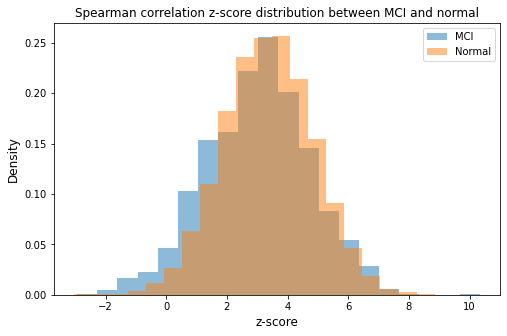

In [90]:
x = list(mci_corr_z.values())
y = list(normal_corr_z.values())
plt.figure(figsize=(8,5))
plt.hist(x, 20, alpha=0.5, label='MCI',density=True)
plt.hist(y, 20, alpha=0.5, label='Normal',density=True)
plt.legend(loc='upper right')
plt.title('Spearman correlation z-score distribution between MCI and normal')
plt.xlabel('z-score',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.savefig(output_path + 'spearman_corr_zscore_distribution.png',dpi = 300)
plt.show()

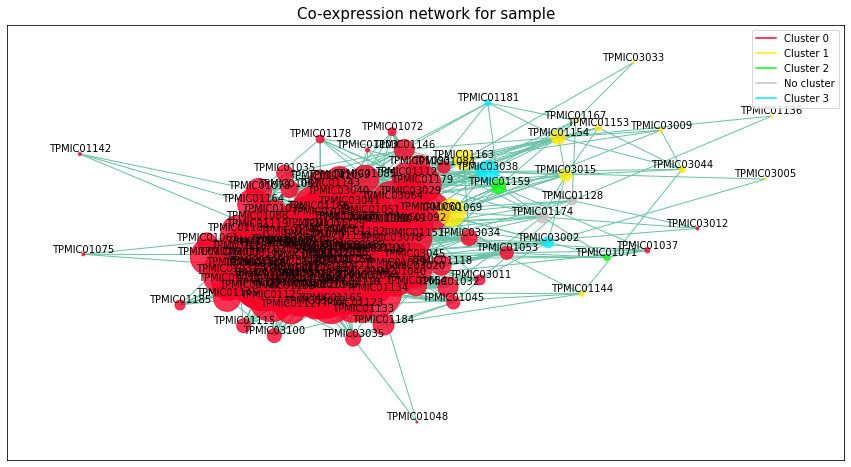

In [67]:
g = create_corr_network(network_df,fisher_z_transform=True)
filter_corr_network(g,5,pos_only=True)
mcl_clustering(g)
plot_corr_network(g,'Co-expression network for sample',output_path + 'co-expression_net_by_people_normal_only_scc_07.png',figsize = (15,8),fontsize = 10)

### consensus clustering

In [4]:
from sklearn.preprocessing import StandardScaler

X = candidate_df.to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(X)

df = pd.DataFrame(x,index=candidate_df.index,columns=candidate_df.columns)

In [6]:
idx = np.where(metadata['Diagnosis'] == 'MCI',True,False)
df = df.loc[:,idx]
df.to_csv('/home/bruce1996/data/MCI/metaphlan_result/standard_candidate_table_mci_only.txt',sep='\t')

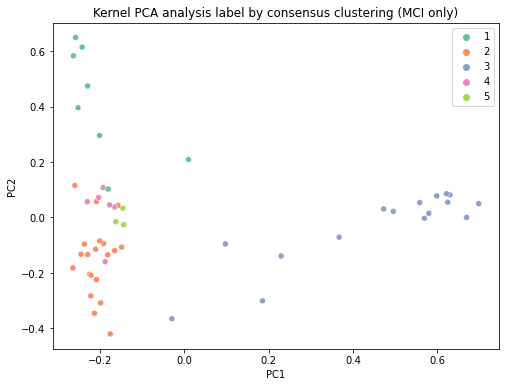

In [141]:
###pca 
from sklearn.decomposition import PCA,KernelPCA

plot_df = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/consensus_clustering_mci_only.txt',sep='\t',index_col=0)
kernel = 'rbf'
pca = KernelPCA(n_components=2,kernel=kernel)
X = df.to_numpy()
pca_r = pca.fit_transform(X.T)
plot_df['PC1'] = pca_r[:,0]
plot_df['PC2'] = pca_r[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data  = plot_df ,x = 'PC1',y='PC2',hue='cluster',palette='Set2')
if kernel == None :
    pc1_variance = round(pca.explained_variance_ratio_[0] * 100,2)
    pc2_variance = round(pca.explained_variance_ratio_[1] * 100,2)
    plt.xlabel("PC1 (" + str(pc1_variance) + ")")
    plt.ylabel("PC2 (" + str(pc2_variance) + ")")

plt.title("Kernel PCA analysis label by consensus clustering (MCI only)")
plt.legend(loc='upper right')
plt.savefig(output_path + 'mci_only_consensus_rbf_pca_with_std.png')

In [23]:
consensus_cluster = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/consensus_clustering.txt',sep='\t',index_col=0)
metadata = metadata.loc[consensus_cluster.index]
cluster_df = pd.DataFrame({'Cluster' : consensus_cluster['cluster'],'Diagnosis' : metadata['Diagnosis']})
cluster_df = cluster_df.sort_values(by=['Cluster','Diagnosis'])

In [12]:
lefse_df = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse.res',sep='\t',index_col=0,header=None)
lefse_df.columns = ["Kruskal","Cluster",'LDA','wilconox']
lefse_df.index.name = None

In [25]:
idx = np.where(lefse_df['Cluster'] < 4,True,False)
lefse_s = lefse_df.loc[idx,:].sort_values(by='Cluster').index
lefse_candidate_df = candidate_df.loc[lefse_s,:]
lefse_candidate_df = lefse_candidate_df.loc[:,cluster_df.index]

In [27]:
idx = np.where(cluster_df['Cluster'] < 4 ,True ,False)
lefse_candidate_df = lefse_candidate_df.loc[:,idx]

In [31]:
idx = np.where(lefse_df['Cluster'] < 4,True,False)
lefse_df = lefse_df.loc[idx,:].sort_values(by='Cluster')
lefse_df = lefse_df.loc[lefse_candidate_df.index,:]

In [49]:
lefse_candidate_df.to_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse_candidate.txt',sep = '\t')

In [51]:
cluster_df.loc[lefse_candidate_df.columns,'Cluster'].to_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse_candidate_label.txt',sep = '\t')

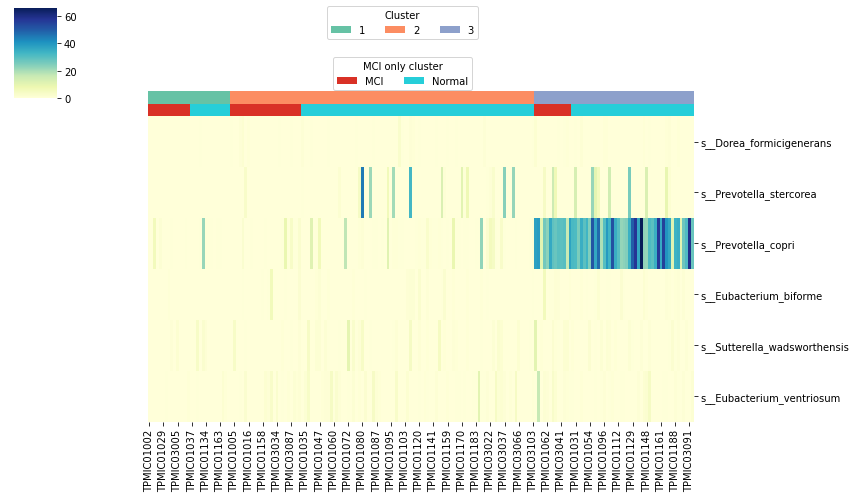

In [46]:
from matplotlib import cm
from matplotlib.pyplot import gcf

cluster = cluster_df.loc[lefse_candidate_df.columns,'Cluster'].values
cluster_lut = dict(zip( set(cluster),  [cm.Set2(x) for x in range(10)] ))
col_colors = pd.Series(cluster).map(cluster_lut)

cluster2 = cluster_df.loc[lefse_candidate_df.columns,'Diagnosis'].values
cluster2_lut = {'MCI': (0.85, 0.192, 0.15000000000000002),'Normal': (0.15000000000000002, 0.8079999999999997, 0.85)}
col_colors2 = pd.Series(cluster2).map(cluster2_lut)

i = 3
idx = lefse_df['Cluster'] == i 
plot_df = lefse_candidate_df.loc[idx,:]

g = sns.clustermap(plot_df, cmap="YlGnBu",
                row_cluster=False, 
                col_cluster=False,
                col_colors=[col_colors,col_colors2],
                linewidths=0, figsize=(12,7))

for label in set(cluster):
    g.ax_col_dendrogram.bar(0, 0, color=cluster_lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.95), bbox_transform=gcf().transFigure)

for label in set(cluster2):
    g.ax_row_dendrogram.bar(0, 0, color=cluster2_lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='MCI only cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.85), bbox_transform=gcf().transFigure)

plt.savefig(output_path + 'lefse_candidate_of_consensus_cluster' + str(i) + '.png',dpi = 300,bbox_inches = 'tight')

/tmp/ipykernel_494705/2773971052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Species'] = plot_df.index
/tmp/ipykernel_494705/2773971052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['baseMean'] = plot_df['baseMean'] / 100
/tmp/ipykernel_494705/2773971052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

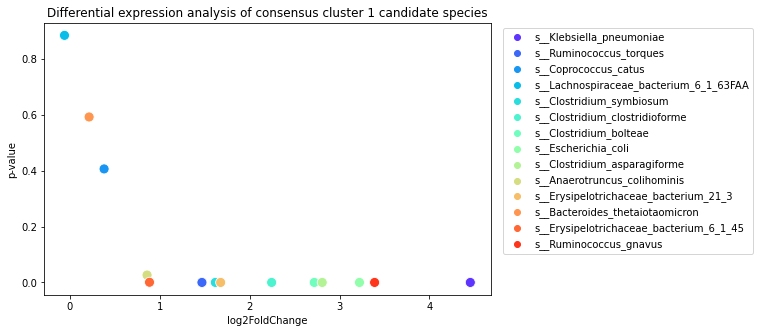

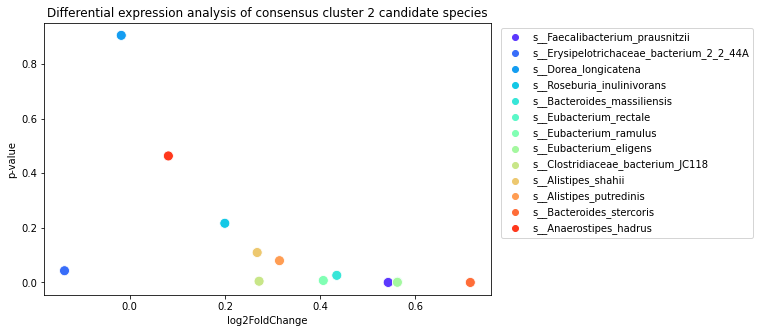

In [82]:
for c in range(1,3) : 
    deseq_df = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse_deseq_cluster' + str(c) + '.txt',sep='\t',index_col=0)

    idx = lefse_df['Cluster'] == c
    plot_df = deseq_df.loc[idx,:]
    plot_df['Species'] = plot_df.index
    plot_df['baseMean'] = plot_df['baseMean'] / 100
    plt.figure(figsize=(8,5))
    sns.scatterplot(data = plot_df,x = 'log2FoldChange',y='padj',hue='Species',s=100,palette='rainbow')
    plt.legend(bbox_to_anchor=(1.6,1))
    plt.ylabel('p-value')
    plt.title("Differential expression analysis of consensus cluster " + str(c) + ' candidate species')
    plt.savefig(output_path + 'lefse_deseq_of_cluster' + str(c) + '.png',dpi = 300 , bbox_inches = 'tight')

In [83]:
output_path

'/home/bruce1996/data/pr/0809/'

/tmp/ipykernel_494705/4191367353.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Species'] = plot_df.index
/tmp/ipykernel_494705/4191367353.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['baseMean'] = plot_df['baseMean'] / 100


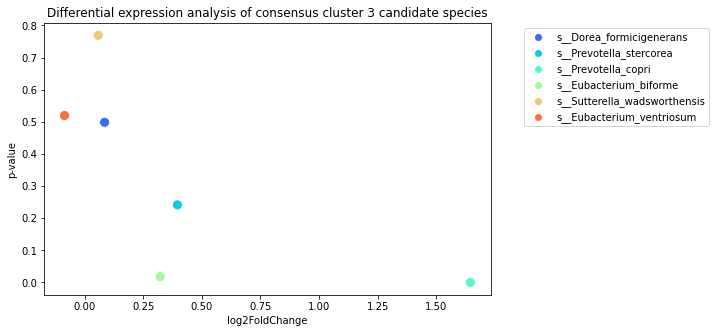

In [78]:
c = 3
deseq_df = pd.read_csv('/home/bruce1996/data/MCI/metaphlan_result/lefse_deseq_cluster' + str(c) + '.txt',sep='\t',index_col=0)

idx = lefse_df['Cluster'] == c
plot_df = deseq_df.loc[idx,:]
plot_df['Species'] = plot_df.index
plot_df['baseMean'] = plot_df['baseMean'] / 100
plt.figure(figsize=(8,5))
sns.scatterplot(data = plot_df,x = 'log2FoldChange',y='padj',hue='Species',s=100,palette='rainbow')
plt.legend(bbox_to_anchor=(1.5,1))
plt.ylabel('p-value')
plt.title("Differential expression analysis of consensus cluster " + str(c) + ' candidate species')
plt.savefig(output_path + 'lefse_deseq_of_cluster' + str(c) + '.png',dpi = 300 , bbox_inches = 'tight')

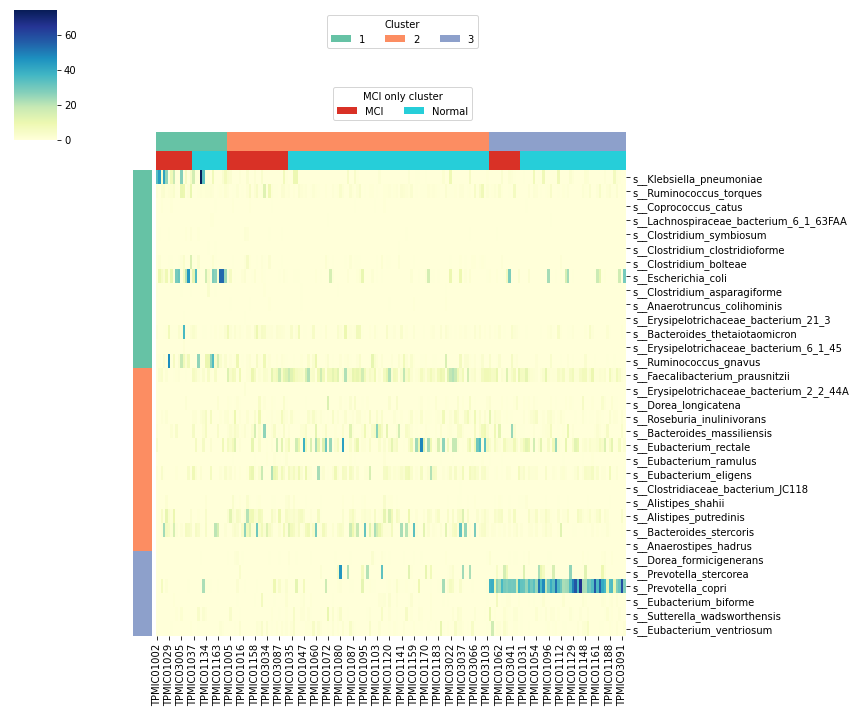

In [41]:
from matplotlib import cm
from matplotlib.pyplot import gcf

cluster = cluster_df.loc[lefse_candidate_df.columns,'Cluster'].values
cluster_lut = dict(zip( set(cluster),  [cm.Set2(x) for x in range(10)] ))
col_colors = pd.Series(cluster).map(cluster_lut)

cluster2 = cluster_df.loc[lefse_candidate_df.columns,'Diagnosis'].values
cluster2_lut = {'MCI': (0.85, 0.192, 0.15000000000000002),'Normal': (0.15000000000000002, 0.8079999999999997, 0.85)}
col_colors2 = pd.Series(cluster2).map(cluster2_lut)

candidate = lefse_df['Cluster'].values
candidate_lut = dict(zip(set(candidate),[cm.Set2(x) for x in range(10)]))
row_colors = pd.Series(candidate).map(candidate_lut)

plot_df = lefse_candidate_df

g = sns.clustermap(plot_df, cmap="YlGnBu",
                row_cluster=False, 
                col_cluster=False,
                col_colors=[col_colors,col_colors2],
                row_colors=[row_colors],
                linewidths=0, figsize=(12,10))

for label in set(cluster):
    g.ax_col_dendrogram.bar(0, 0, color=cluster_lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.95), bbox_transform=gcf().transFigure)

for label in set(cluster2):
    g.ax_row_dendrogram.bar(0, 0, color=cluster2_lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='MCI only cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.85), bbox_transform=gcf().transFigure)

plt.savefig(output_path + 'lefse_candidate_of_consensus_cluster.png',dpi = 300,bbox_inches = 'tight')

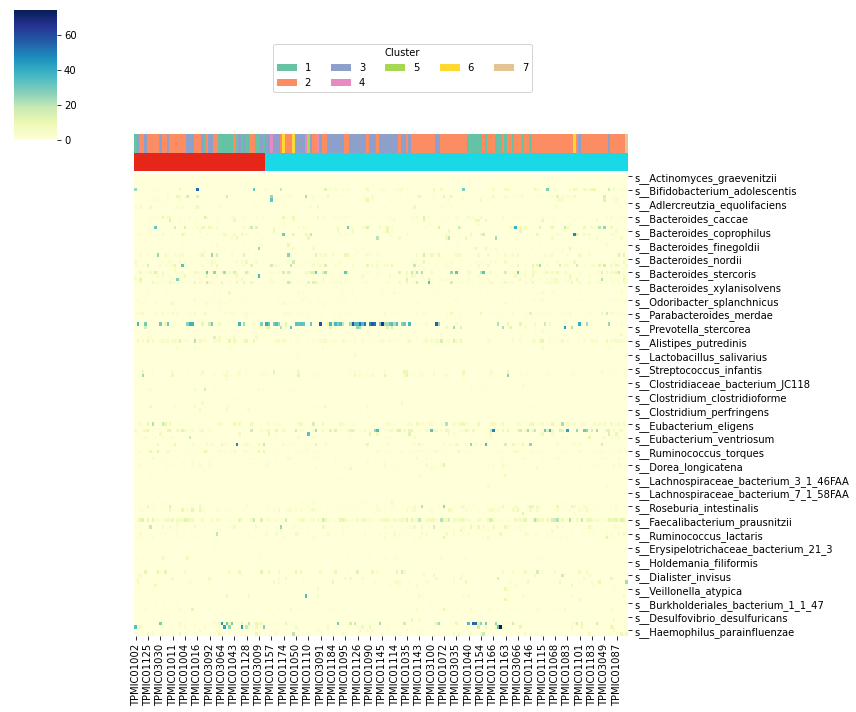

In [167]:
from matplotlib import cm
from matplotlib.pyplot import gcf

cluster = consensus_cluster['cluster'].values
cluster_lut = dict(zip( set(cluster),  [cm.Set2(x) for x in range(10)] ))
col_colors = pd.Series(cluster).map(cluster_lut)

diagnosis = metadata['Diagnosis'].values
lut = dict(zip( ['MCI','Normal'], sns.hls_palette(len(set(diagnosis)),l=0.5, s=0.8)   ))
row_colors = pd.Series(diagnosis).map(lut)

plot_df = candidate_df

g = sns.clustermap(plot_df, cmap="YlGnBu",
                row_cluster=False, 
                col_cluster=False,
                col_colors=[col_colors,row_colors],
                linewidths=0, figsize=(12,10 ))

for label in set(cluster):
    g.ax_col_dendrogram.bar(0, 0, color=cluster_lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.9), bbox_transform=gcf().transFigure)
plt.savefig(output_path + 'consensus_clustering_heatmap_by_candidate_species_sort_by_diagnosis.png',dpi = 300,bbox_inches = 'tight')

### TSEA

In [13]:
from GSEA import taxonomy_enrich_analysis,enrich_score,permutation
###pesudo code
tsea_output =  '/home/bruce1996/data/MCI/tsea/'
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0).sort_values(by='log2FoldChange',ascending=False)

tsea = taxonomy_enrich_analysis(deseq_output=deseq_df,metaphlan_output=meta_df,humann_index=None,graph=g,taxonomy=None)
node_df = tsea.TSEA(mode='Node',sorted=False).sort_values(by='Pathway')
edge_df = tsea.TSEA(mode='Edge',sorted=False).sort_values(by='Pathway')

df = pd.DataFrame({'Name' : node_df['Pathway'],'Node-pseudo-F' : node_df['p-value'],'Edge-pseudo-F' : edge_df['p-value']})
#df.to_csv(tsea_output + 'overall_positive_corr_tsea_result.txt',sep='\t')

taxonomy list length : 410
Calculate enrichment score of 1 / 10  pathway : Cluster 1
TSEA of pathway : Cluster 1 cost 0.60 s
Calculate enrichment score of 2 / 10  pathway : Cluster 0
TSEA of pathway : Cluster 0 cost 0.01 s
Calculate enrichment score of 3 / 10  pathway : Cluster 9
TSEA of pathway : Cluster 9 cost 0.01 s
Calculate enrichment score of 4 / 10  pathway : Cluster 3
TSEA of pathway : Cluster 3 cost 0.01 s
Calculate enrichment score of 5 / 10  pathway : Cluster 5
TSEA of pathway : Cluster 5 cost 0.01 s
Calculate enrichment score of 6 / 10  pathway : Cluster 8
TSEA of pathway : Cluster 8 cost 0.01 s
Calculate enrichment score of 7 / 10  pathway : Cluster 7
TSEA of pathway : Cluster 7 cost 0.01 s
Calculate enrichment score of 8 / 10  pathway : Cluster 4
TSEA of pathway : Cluster 4 cost 0.01 s
Calculate enrichment score of 9 / 10  pathway : Cluster 2
TSEA of pathway : Cluster 2 cost 0.01 s
Calculate enrichment score of 10 / 10  pathway : Cluster 6
TSEA of pathway : Cluster 6 cost

/home/bruce1996/repo/Microbiome_health_indicator/GSEA.py:110: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)


taxonomy list length : 83845
Calculate enrichment score of 1 / 10  pathway : Cluster 1
TSEA of pathway : Cluster 1 cost 2.00 s
Calculate enrichment score of 2 / 10  pathway : Cluster 0
TSEA of pathway : Cluster 0 cost 2.01 s
Calculate enrichment score of 3 / 10  pathway : Cluster 9
TSEA of pathway : Cluster 9 cost 2.01 s
Calculate enrichment score of 4 / 10  pathway : Cluster 3
TSEA of pathway : Cluster 3 cost 2.00 s
Calculate enrichment score of 5 / 10  pathway : Cluster 5
TSEA of pathway : Cluster 5 cost 2.00 s
Calculate enrichment score of 6 / 10  pathway : Cluster 8
TSEA of pathway : Cluster 8 cost 2.01 s
Calculate enrichment score of 7 / 10  pathway : Cluster 7
TSEA of pathway : Cluster 7 cost 2.00 s
Calculate enrichment score of 8 / 10  pathway : Cluster 4
TSEA of pathway : Cluster 4 cost 2.01 s
Calculate enrichment score of 9 / 10  pathway : Cluster 2
TSEA of pathway : Cluster 2 cost 2.00 s
Calculate enrichment score of 10 / 10  pathway : Cluster 6
TSEA of pathway : Cluster 6 co

In [17]:
nx.get_node_attributes(g,'Cluster')
cluster_list = list(set(nx.get_node_attributes(g,'Cluster').values()))
cluster_list.remove('No cluster')
for c in cluster_list :
    g_sub = subgraph(g,attr='Cluster',candidate=c)
    if len(g_sub.node()) < 10 :
        pass
    else :
        represent_s,max_degree = sorted(g.degree, key=lambda x: x[1], reverse=True)[0]
        title = 'Co-expression network for' + ' ' + c + ' ' + represent_s
        file_name = output_path + 'co-expression-network' + '-' + represent_s + '.png'
        plot_corr_network(g_sub,title,file_name,figsize = (15,8),fontsize=12)
        node_scatter_subplot(g_sub,candidate_df,l,'Cluster 0 (Streptococcus) ',output_path + 'tmp.png','MCI','normal')

### main function

In [37]:
from GSEA import taxonomy_enrich_analysis,enrich_score,permutation

def main() :
    
    tsea_output =  '/home/bruce1996/data/MCI/tsea/'
    output_path = '/home/bruce1996/data/pr/0711/'
    deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
    deseq_df = pd.read_csv(deseq_output,sep='\t',index_col=0)
    metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
    meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
    metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
    diagnosis_idx = np.where(metadata['Diagnosis'] == 'MCI',True,False)
    ### candidate species
    selected_df = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt',sep = '\t',header=None)
    selected_s = selected_df.iloc[:,0].values
    candidate_df = meta_df.loc[selected_s,:]

    condition = ['Overall','MCI','Normal']
    percentile = 90
    #node_num_dict = {'Overall' : 10,'MCI' : 5,'Normal' : 5}

    for con in condition :
        
        if con == 'Overall' :
            metaphlan = meta_df
            candidate = candidate_df
        elif con == 'MCI' :
            metaphlan = meta_df.loc[:,diagnosis_idx]
            candidate = candidate_df.loc[:,diagnosis_idx]
        elif con == 'Normal' :
            metaphlan = meta_df.loc[:,diagnosis_idx == False]
            candidate = candidate_df.loc[:,diagnosis_idx == False]

        g = create_corr_network(candidate)
        zscore_dict = nx.get_edge_attributes(g,'weight')
        percentile_threshold = zscore_percentile(zscore_dict,percentile)
        filter_corr_network(g,percentile_threshold,pos_only=True)
        mcl_clustering(g)
        plot_corr_network(g,con +' '+'co-expression network for candidate species',output_path + con + '-co-expression-network.png',figsize = (15,8))
        #### taxonomy set enrichment analysis
        tsea = taxonomy_enrich_analysis(deseq_output=deseq_df,metaphlan_output=metaphlan,humann_index=None,graph=g,taxonomy=None)
        node_df = tsea.TSEA(mode='Node',sorted=False).sort_values(by='Pathway')
        edge_df = tsea.TSEA(mode='Edge',sorted=False).sort_values(by='Pathway')
        tsea_df = pd.DataFrame({'Name' : node_df['Pathway'],'Node-pseudo-F' : node_df['p-value'],'Edge-pseudo-F' : edge_df['p-value']})
        tsea_df.index = tsea_df['Name'].values
        tsea_df.to_csv(tsea_output + con + '-TSEA-output.txt',sep='\t')

        ###plot sub network
        nx.get_node_attributes(g,'Cluster')
        cluster_list = list(set(nx.get_node_attributes(g,'Cluster').values()))
        cluster_list.remove('No cluster')
        for c in cluster_list :
            g_sub = subgraph(g,attr='Cluster',candidate=c)
            print("Cluster : {c} node pseudo F : {node}, edge pseudo F : {edge}".format(c=c,node = tsea_df.loc[c,'Node-pseudo-F'],edge =tsea_df.loc[c,'Edge-pseudo-F'] ))
            if tsea_df.loc[c,'Node-pseudo-F'] < 0.05 and tsea_df.loc[c,'Edge-pseudo-F'] < 0.05 :

                represent_s,_ = sorted(g_sub.degree, key=lambda x: x[1], reverse=True)[0]
                #stat of subnetwork member
                sub_s = list(g_sub.nodes())
                sub_deseq_df = deseq_df.loc[sub_s,:].copy()
                df_file_name = output_path + con + '-' + 'co-expression-subnetwork' + '-' + represent_s + '.txt'
                sub_deseq_df.to_csv(df_file_name,sep='\t')
                ##plot subnetwork
                subnetwork_title = con + ' ' + 'subnetwork for' + ' ' + c + ' ' + '('+ represent_s + ')'
                file_name = output_path + con + '-' + 'co-expression-subnetwork' + '-' + represent_s + '.png'
                plot_corr_network(g_sub,subnetwork_title,file_name,figsize = (15,8),fontsize=12)
                if con == 'Overall' :
                    scatter_title = 'Subnetwork scatterplot for' + ' ' + c + ' ' + '('+ represent_s + ')'
                    scatter_name = output_path + 'Subnetwork scatterplot for' + ' ' + c + ' ' + '('+ represent_s + ')' + '.png'
                    node_scatter_subplot(g_sub,candidate,diagnosis_idx,scatter_title,scatter_name,'MCI','normal')
            else :
                pass


In [ ]:
main()

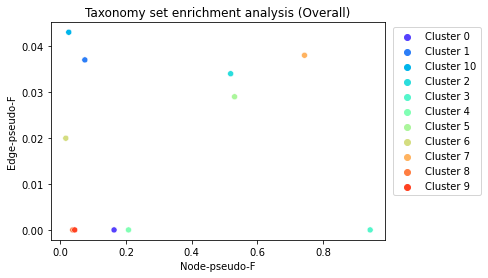

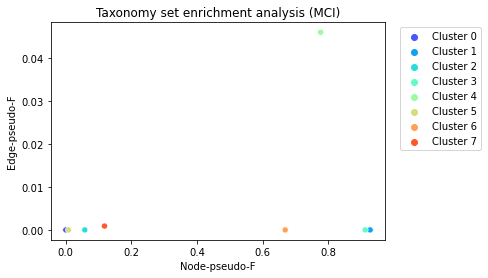

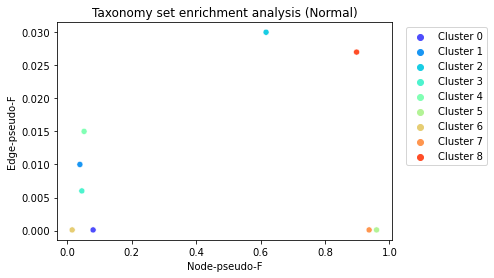

In [56]:
tsea_output = '/home/bruce1996/data/MCI/tsea/'
con = ['Overall','MCI','Normal']
for c in con :
    name = tsea_output + c + '-TSEA-output.txt'
    df = pd.read_csv(name,sep='\t',index_col=0)
    edge_p = df['Edge-pseudo-F'].values
    sns.scatterplot(data = df,x = 'Node-pseudo-F',y='Edge-pseudo-F',hue = 'Name',palette='rainbow')
    plt.title('Taxonomy set enrichment analysis ' + '(' + c + ')')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.savefig(output_path + c + '-TSEA-scatterplot.png',bbox_inches='tight',dpi = 300)
    plt.show()

### import kgml file

In [25]:
from Bio.KEGG.KGML import KGML_parser
#https://biopython.org/docs/1.76/api/Bio.KEGG.KGML.KGML_pathway.html

pathway = KGML_parser.read(open(kgml, 'r'))
component_list = np.empty(29,dtype= object)
for idx,c in enumerate(pathway.compounds) :
    component_list[idx] = c.name

29
cpd:C02656


In [114]:
kgml2com_dict = dict()
component_dict = dict()
kgml_path = '/home/bruce1996/data/MCI/kegg/'
kgml_list = os.listdir(kgml_path)

n=0
for f in kgml_list :
    if f[-4:] != 'kgml' :
        pass
    else :
        n += 1
        print('Parse %d st kgml file : %s' % (n,f))
        map_name = 'map' + f[3:]
        filename = kgml_path + f
        ##parse kgml file
        pathway = KGML_parser.read(open(filename, 'r'))
        n_component = len(pathway.compounds)
        component_list = np.empty(n_component,dtype= object)
        for idx,c in enumerate(pathway.compounds) :
            component_list[idx] = c.name
            if c.name not in component_dict.keys() :
                component_dict[c.name] = 0
            else :
                component_dict[c.name] += 1

        if map_name not in kgml2com_dict.keys() :
            kgml2com_dict[map_name] = component_list


Parse 1 st kgml file : lcx00650.kgml
Parse 2 st kgml file : lpl00780.kgml
Parse 3 st kgml file : lfe01110.kgml
Parse 4 st kgml file : lca00380.kgml
Parse 5 st kgml file : lca00361.kgml
Parse 6 st kgml file : lfe00680.kgml
Parse 7 st kgml file : lpl00460.kgml
Parse 8 st kgml file : lre00630.kgml
Parse 9 st kgml file : lre00660.kgml
Parse 10 st kgml file : lpl00030.kgml
Parse 11 st kgml file : lre00520.kgml
Parse 12 st kgml file : lpl00521.kgml
Parse 13 st kgml file : lca00430.kgml
Parse 14 st kgml file : lca03430.kgml
Parse 15 st kgml file : lre02024.kgml
Parse 16 st kgml file : lrh03010.kgml
Parse 17 st kgml file : lcx00780.kgml
Parse 18 st kgml file : lac01212.kgml
Parse 19 st kgml file : lcx00541.kgml
Parse 20 st kgml file : bcoa00020.kgml
Parse 21 st kgml file : lcx00770.kgml
Parse 22 st kgml file : lac01502.kgml
Parse 23 st kgml file : lre01212.kgml
Parse 24 st kgml file : lpl03430.kgml
Parse 25 st kgml file : lca01120.kgml
Parse 26 st kgml file : lre00350.kgml
Parse 27 st kgml fil

In [46]:
map_list = [x.split('.')[0] for x in kgml2com_dict.keys()]

In [116]:
component_dict

{'cpd:C03046': 17,
 'cpd:C01769': 17,
 'cpd:C00810': 25,
 'cpd:C03044': 17,
 'cpd:C06010': 70,
 'cpd:C00022': 402,
 'cpd:C00042': 162,
 'cpd:C00122': 148,
 'cpd:C01384': 44,
 'cpd:C00497': 17,
 'cpd:C02527': 17,
 'cpd:C00246': 17,
 'cpd:C00136': 79,
 'cpd:C01412': 26,
 'cpd:C00877': 100,
 'cpd:C02411': 34,
 'cpd:C03058': 17,
 'cpd:C02630': 25,
 'cpd:C00026': 189,
 'cpd:C00024': 326,
 'cpd:C00356': 44,
 'cpd:C00332': 120,
 'cpd:C00164': 67,
 'cpd:C01089': 17,
 'cpd:C04546': 17,
 'cpd:C03561': 52,
 'cpd:C01144': 99,
 'cpd:C02331': 17,
 'cpd:C06143': 17,
 'cpd:C00989': 35,
 'cpd:C00232': 79,
 'cpd:C00334': 65,
 'cpd:C00025': 218,
 'cpd:C06142': 35,
 'cpd:C06144': 17,
 'cpd:C06145': 8,
 'cpd:C06146': 8,
 'cpd:C00741': 17,
 'cpd:C11062': 35,
 'cpd:C00091': 123,
 'cpd:C20657': 17,
 'cpd:C21390': 35,
 'cpd:C00207': 17,
 'cpd:C17530': 17,
 'cpd:C00132': 53,
 'cpd:C01845': 17,
 'cpd:C20783': 17,
 'cpd:C02656': 26,
 'cpd:C01063': 52,
 'cpd:C01092': 26,
 'cpd:C01909': 26,
 'cpd:C01037': 26,
 'cpd